<a href="https://colab.research.google.com/github/ahsanabbas123/NLP-From-Scratch/blob/master/ClassifyingNamesRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path):
  return glob.glob(path)

print(findFiles('/content/data/*.txt'))
files = findFiles('/content/data/*.txt')

import unicodedata
import string

all_letters = string.ascii_letters + ".,;'"
n_letters = len(all_letters)

# Unicode to ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

category_lines = {}
all_categories = []

# read a file and split into lines
def readLines(filename):
  lines = open(filename, encoding = 'utf-8').read().strip().split('\n')
  return [unicodeToAscii(line) for line in lines]

for filename in files:
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = readLines(filename)
  category_lines[category] = lines

n_categories = len(all_categories) 

['/content/data/Dutch.txt', '/content/data/Spanish.txt', '/content/data/Vietnamese.txt', '/content/data/Italian.txt', '/content/data/Russian.txt', '/content/data/Japanese.txt', '/content/data/French.txt', '/content/data/Arabic.txt', '/content/data/Chinese.txt', '/content/data/English.txt', '/content/data/Korean.txt', '/content/data/Portuguese.txt', '/content/data/German.txt', '/content/data/Greek.txt', '/content/data/Irish.txt', '/content/data/Scottish.txt', '/content/data/Czech.txt', '/content/data/Polish.txt']
Slusarski


In [0]:
# one-hot vector encoding to tensors

import torch

def letterToIndex(letter):
  return all_letters.find(letter)

def letterToTensor(letter):
  tensor = torch.zeros(1,n_letters)
  tensor[0][letterToIndex(letter)] = 1
  return tensor

def lineToTensor(line):
  tensor = torch.zeros(len(line),1, n_letters)
  for li, letter in enumerate(line):
    tensor[li][0][letterToIndex(letter)] = 1
  return tensor

print(letterToTensor('J'))
print(lineToTensor('adfljh').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
torch.Size([6, 1, 56])


In [0]:
# Creating the network
import torch.nn as nn

class RNN(nn.Module):

  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()
    
    self.hidden_size = hidden_size

    self.i2o = nn.Linear(input_size + hidden_size, output_size)
    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)

    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input, hidden):
    combined = torch.cat((input, hidden),1)
    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.softmax(output)
    return output, hidden
  
  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

In [0]:
# running one step
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print (output) 

tensor([[-2.8456, -2.9116, -2.8017, -2.8282, -2.8238, -2.8599, -2.9223, -2.9537,
         -2.9045, -2.9351, -2.9035, -3.0051, -2.8668, -3.0024, -2.9064, -2.9250,
         -2.7780, -2.8865]], grad_fn=<LogSoftmaxBackward>)


In [0]:
# helper functions

# interpret the output 
def categoryFromOutput(output):
  values, indices = output.topk(1)
  category_index = indices[0].item()
  return all_categories[category_index], category_index

print(categoryFromOutput(output))

# to get a random sample quickly
import random

def randomChoice(Lst):
  return Lst[random.randint(0, len(Lst)-1)]


def randomTrainingExample():
  # choose a category i.e a random country
  category = randomChoice(all_categories)
  # line is a random word here in a specific country
  line = randomChoice(category_lines[category])
  # their tensors
  category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
  line_tensor = lineToTensor(line)
  return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

('Czech', 16)
category = Spanish / line = Robledo
category = Italian / line = Allegri
category = Russian / line = Bagomaev
category = Arabic / line = Nassar
category = Czech / line = Grozmanova
category = Irish / line = Mohan
category = Italian / line = Dipietro
category = Spanish / line = Oliver
category = Irish / line = Cathan
category = English / line = Calvert


In [0]:
# training the network: 

criterion = nn.NLLLoss()

lr = 0.005

def train(category_tensor, line_tensor):
  hidden = rnn.initHidden()
  rnn.zero_grad()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)
  
  loss = criterion(output, category_tensor)
  loss.backward()

  for p in rnn.parameters():
    p.data.add_(-lr, p.grad.data)

  return output, loss.item()

In [0]:
import time 
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
  now = time.time()
  s = now - since
  m = math.floor(s / 60)
  s -= m * 60
  return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
  
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output, loss = train(category_tensor, line_tensor)
  current_loss += loss

  if iter % print_every == 0:
    guess, guess_i = categoryFromOutput(output)
    correct = 'correct!' if guess == category else 'wrong! (%s)' % category
    print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct)) 
  
  if iter % plot_every == 0:
    all_losses.append(current_loss / plot_every)
    current_loss = 0

5000 5% (0m 6s) 2.1186 Mulinov / Russian correct!
10000 10% (0m 12s) 3.0668 Young / Vietnamese wrong! (Scottish)
15000 15% (0m 19s) 3.6454 Hughes / Vietnamese wrong! (Scottish)
20000 20% (0m 25s) 1.4006 Modugno / Italian correct!
25000 25% (0m 32s) 2.2010 Yanko / Polish wrong! (Russian)
30000 30% (0m 38s) 0.7989 Hagiwara / Japanese correct!
35000 35% (0m 45s) 2.0415 Walker / German wrong! (Scottish)
40000 40% (0m 51s) 2.5316 Haanraads / Portuguese wrong! (Dutch)
45000 45% (0m 57s) 0.9059 Narvaez / Spanish correct!
50000 50% (1m 4s) 3.2632 Macias / Portuguese wrong! (Spanish)
55000 55% (1m 10s) 0.6804 Ran / Chinese correct!
60000 60% (1m 16s) 1.3389 White / Scottish correct!
65000 65% (1m 23s) 0.2294 Slusarczyk / Polish correct!
70000 70% (1m 29s) 0.7280 Demas / Greek correct!
75000 75% (1m 35s) 0.6838 Ra / Korean correct!
80000 80% (1m 42s) 2.1313 Klerkse / Greek wrong! (Dutch)
85000 85% (1m 48s) 0.1744 Truong / Vietnamese correct!
90000 90% (1m 54s) 0.1931 Tsuruga / Japanese correct!


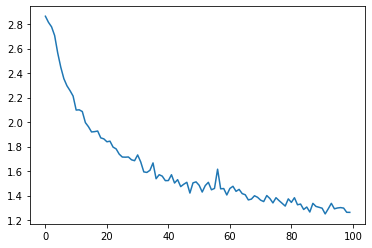

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

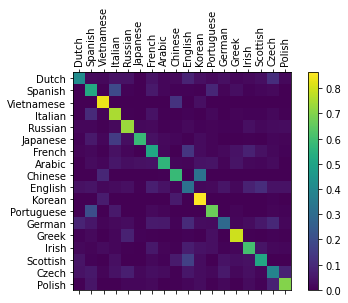

In [0]:
# evaluation
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
  hidden = rnn.initHidden()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)
  
  return output

# Going through examples and recording which are correct

for i in range(n_confusion):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output = evaluate(line_tensor)
  guess, guess_i = categoryFromOutput(output)
  category_i = all_categories.index(category)
  confusion[category_i][guess_i] += 1

# normalize the confusion matrix
for i in range(n_categories):
  confusion[i] = confusion[i] / confusion[i].sum()

#  Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [0]:
# predicting on input

def predict(input_line, n_predictions=3):
  print('\n> %s' % input_line)
  with torch.no_grad():
    output = evaluate(lineToTensor(input_line))

    topv, topi = output.topk(n_predictions)
    predictions = []
    for i in range(n_predictions):
      value = topv[0][i].item()
      category_index = topi[0][i].item()
      print('(%.2f) %s' % (value, all_categories[category_index]))
      predictions.append([value, all_categories[category_index]])



In [0]:
predict('Issa')
predict('Rafi')
predict('Jamil')
predict('Rustom')


> Issa
(-1.25) Japanese
(-1.53) Czech
(-1.55) Arabic

> Rafi
(-0.22) Italian
(-2.88) Korean
(-3.24) Irish

> Jamil
(-0.72) Czech
(-2.16) Russian
(-2.38) Arabic

> Rustom
(-1.33) Spanish
(-1.67) English
(-1.87) French
